# Gene essentiality

In [7]:
%%capture
%run gene_annotation.ipynb

from colorama import init, Fore, Style
from cobra import Model, Reaction
from cobra.io import read_sbml_model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

model = read_sbml_model('Files/iCGB21FR.xml')

lys_exp_rxn = Reaction("LYSt3r")
lys_exp_rxn.name = "L lysine transport out via proton antiport reversible"
lys_exp_rxn.add_metabolites({model.metabolites.h_e: -1, model.metabolites.lys__L_c: -1, model.metabolites.h_c: 1, model.metabolites.lys__L_e: 1})
lys_exp_rxn.gene_reaction_rule = "( Mbar_A2583 or Mbar_A3244 )"
lys_exp_rxn.lower_bound, lys_exp_rxn.upper_bound = 0, 1000

model.add_reactions([lys_exp_rxn])

In [8]:
model.objective = model.reactions.Growth

essentiality = {}

for gene in model.genes:
    with model:
        gene.knock_out()
        essentiality[getProteinID(gene.id)] = model.optimize()["Growth"]

        
df = pd.DataFrame.from_dict(essentiality, orient='index')
df = df.rename(columns={0: 'Growth'})
df = df.sort_values('Growth')
df = df[df.index.to_series().str.startswith("WP_", na=False)]
df.loc[df['Growth'] < 0, 'Growth'] = 0
df.loc[(df['Growth'] < 0) | (df['Growth'] < 1e-10), 'Growth'] = 0
df = df.sort_values(by='Growth')
df

,Growth
WP_003857183,0.00000
WP_011014736,0.00000
WP_011014930,0.00000
WP_011014924,0.00000
WP_011014956,0.00000
...,...
WP_003855225,0.57066
WP_003856473,0.57066
WP_006284182,0.57066
WP_011014850,0.57066


117 essential genes (growth = 0)
27 impactful genes (growth < MAX_growth)
653 non impactful genes (growth = MAX_growth)


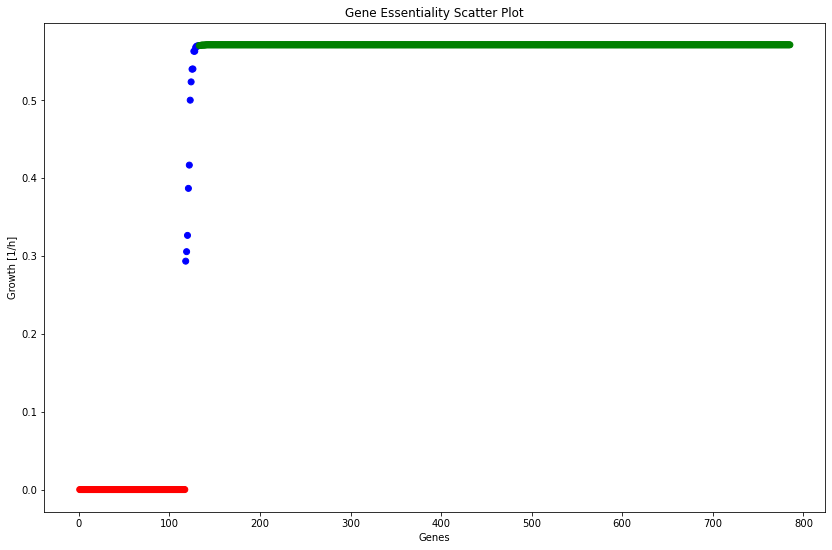

In [9]:
MAX_growth = 0.57066
df['GeneNumber'] = range(1, len(df)+1)

essential_genes = df['Growth'] == 0
impactful_genes = (df['Growth'] > 0) & (df['Growth'] < MAX_growth)
non_impactful_genes = np.isclose(df['Growth'], MAX_growth, atol=1e-3)

count_essential = essential_genes.sum()
count_impactful = impactful_genes.sum()
count_non_impactful = non_impactful_genes.sum()

print(f"{count_essential} essential genes (growth = 0)")
print(f"{count_impactful} impactful genes (growth < MAX_growth)")
print(f"{count_non_impactful} non impactful genes (growth = MAX_growth)")

colors = np.where(essential_genes, 'red', np.where(non_impactful_genes, 'green', 'blue'))

plt.figure(figsize=(14, 9))

plt.grid(False)
plt.scatter(df['GeneNumber'], df['Growth'], c=colors)
plt.xlabel('Genes')
plt.ylabel('Growth [1/h]')
plt.title('Gene Essentiality Scatter Plot')
plt.show()


In [10]:
printText(f"Essential genes (growth = 0): {count_essential} genes \n", Fore.BLUE)
for protein_id in list(df[essential_genes].index):
    printText(f"    {protein_id}-> ", Fore.RED, Style.BRIGHT)
    for reaction in model.reactions:
        for gene in reaction.genes:
            if gene.id == getFullGeneName(protein_id):
                substrates = ' + '.join([f"{metabolite.name}" for metabolite in reaction.reactants])
                products = ' + '.join([f"{metabolite.name}" for metabolite in reaction.products])
                reaction_string = f"{substrates} --> {products}"
                printText(f"        {reaction.id}: {reaction.name}", Fore.BLACK, Style.DIM)
                #print(f" {reaction_string}")
                
                
printText(f"Impactful genes (growth < MAX_growth): {count_impactful} genes \n", Fore.BLUE)
for protein_id in list(df[impactful_genes].index):
    printText(f"    {protein_id}-> ", Fore.RED, Style.BRIGHT)
    for reaction in model.reactions:
        for gene in reaction.genes:
            if gene.id == getFullGeneName(protein_id):
                substrates = ' + '.join([f"{metabolite.name}" for metabolite in reaction.reactants])
                products = ' + '.join([f"{metabolite.name}" for metabolite in reaction.products])
                reaction_string = f"{substrates} --> {products}"
                printText(f"        {reaction.id}: {reaction.name}", Fore.BLACK, Style.DIM)
                #print(f" {reaction_string}")

Essential genes (growth = 0): 117 genes 

    WP_003857183-> 
        ASP1DC: Aspartate 1-decarboxylase
    WP_011014736-> 
        APRAUR: 5-amino-6-(5-phosphoribosylamino)uracil reductase
    WP_011014930-> 
        MTHFR2: 5,10-methylenetetrahydrofolate reductase (NADH)
        MTHFR2_1: 5,10-methylenetetrahydrofolate reductase (NADH)
        MTHFR3: 5 10 methylenetetrahydrofolatereductase  NADPH
    WP_011014924-> 
        PAPPT3: Phospho-N-acetylmuramoyl-pentapeptide-transferase (meso-2,6-diaminopimelate)
    WP_011014956-> 
        ILETA: Isoleucine transaminase
        LEUTA: Leucine transaminase
        VALTA: Valine transaminase
    WP_003854117-> 
        KARA1i: 
        KARA2: Ketol-acid reductoisomerase (2-Acetolactate)
    WP_003859294-> 
        NDPK1: Nucleoside-diphosphate kinase (ATP:GDP)
        NDPK2: Nucleoside-diphosphate kinase (ATP:UDP)
        NDPK3: Nucleoside-diphosphate kinase (ATP:CDP)
        NDPK4: Nucleoside-diphosphate kinase (ATP:dTDP)
        NDPK5: N

        CLt3_2pp: Chloride transport out via proton antiport (2:1) (periplasm)
    WP_003856281-> 
        CTPS1: CTP synthase  NH3
        CTPS2: CTP synthase (glutamine)
    WP_003858194-> 
        DTMPK: DTMP kinase
    WP_011014486-> 
        DHQS: 3-dehydroquinate synthase
    WP_011013670-> 
        OXGDC2: 2-oxoglutarate decarboxylase
        SHCHCS: SHCHCS
        SHCHCS2: 2-succinyl-6-hydroxy-2,4-cyclohexadiene 1-carboxylate synthase
    WP_011013388-> 
        ACHBS: 2-aceto-2-hydroxybutanoate synthase
        ACLS: Acetolactate synthase
    WP_011014479-> 
        DHORTS: Dihydroorotase
    WP_003856018-> 
        RBFSa: Riboflavin synthase
        RBFSb: Riboflavin synthase
    WP_011014798-> 
        FMNAT: FMN adenylyltransferase
        RBFK: Riboflavin kinase
    WP_003863776-> 
        CYTK1: Cytidylate kinase (CMP)
        CYTK2: Cytidylate kinase (dCMP)
        UMPK: UMP kinase
    WP_011015061-> 
        NNATr: Nicotinate-nucleotide adenylyltransferase
    WP_011014

        ADSK: Adenylyl-sulfate kinase
        SADT: Sulfate adenylyltransferase
        SADT2: Sulfate adenyltransferase
    WP_003856053-> 
        TALA: Transaldolase
    WP_003859315-> 
        GLU5K: Glutamate 5-kinase
    WP_003855505-> 
        P5CR: Pyrroline-5-carboxylate reductase
        P5CRx: Pyrroline-5-carboxylate reductase(nadh)
    WP_003859321-> 
        G5SD: Glutamate-5-semialdehyde dehydrogenase
        G5SD2: Glutamate 5 semialdehyde dehydrogenase
    WP_011014907-> 
        CYS: L-cysteine
        CYSTS: Cystathionine beta synthase
    WP_003859878-> 
        FE3t: Ferric iron uptake, plasma membrane
    WP_011014475-> 
        PPCDC: Phosphopantothenoylcysteine decarboxylase
        PPNCL: Phosphopantothenate-cysteine ligase
        PPNCL2: Phosphopantothenate-cysteine ligase
        PPNCL3: 4'-Phosphopantothenate:L-cysteine ligase
    WP_003853648-> 
        ACKr: Acetate kinase
        GART: GAR transformylase-T
    WP_011013978-> 
        AMMQT8_2: S-adenosylm